 # Блок 1. Анализ данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/dl-2025-study-competition-2.zip'
extract_path = '/content/data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.listdir(extract_path)

['sample_submission.csv', 'train.csv', 'test.csv']

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import copy
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [ ]:
import pandas as pd

df = pd.read_csv('/content/data/train.csv')

df.head()

,id,text,labels
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0


In [ ]:
df.columns

Index(['id', 'text', 'labels'], dtype='object')

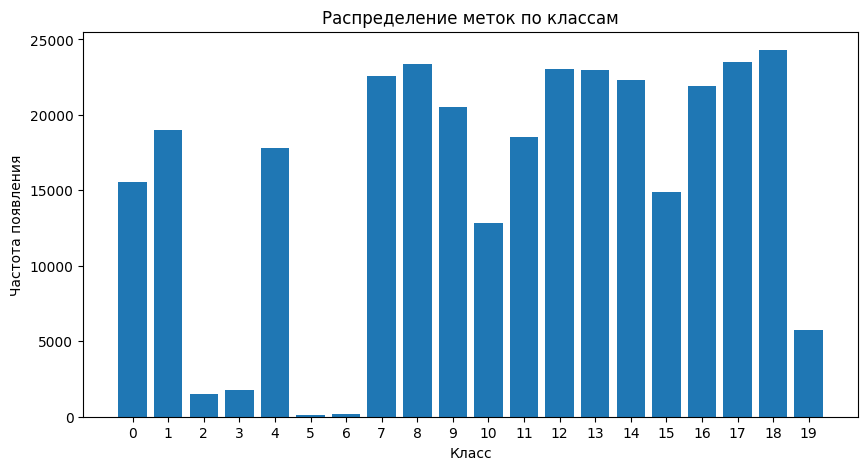

In [ ]:
# преобразуем labels из строки вида "1 0 1 ..." в список из чисел
df['label_vector'] = df['labels'].apply(lambda x: list(map(int, x.strip().split())))
import numpy as np

label_matrix = np.array(df['label_vector'].tolist())

# посчитаем количество 1 в каждом столбце (т.е. в каждом классе)
class_counts = label_matrix.sum(axis=0)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(range(len(class_counts)), class_counts)
plt.xlabel('Класс')
plt.ylabel('Частота появления')
plt.title('Распределение меток по классам')
plt.xticks(range(len(class_counts)))
plt.show()


На графике видно, что некоторые классы (4, 7, 8, 13, 18, 19) встречаются более чем в 20 000 примерах, в то время как другие (2, 3, 5, 6) имеют частоту появления менее 5 000. Особенно редкими являются классы 5 и 6, каждый из которых появляется в крайне малом числе текстов. Это говорит о сильной несбалансированности классов, что следует учитывать при обучении модели, например, с помощью взвешивания лосса или использования специальных методов балансировки.

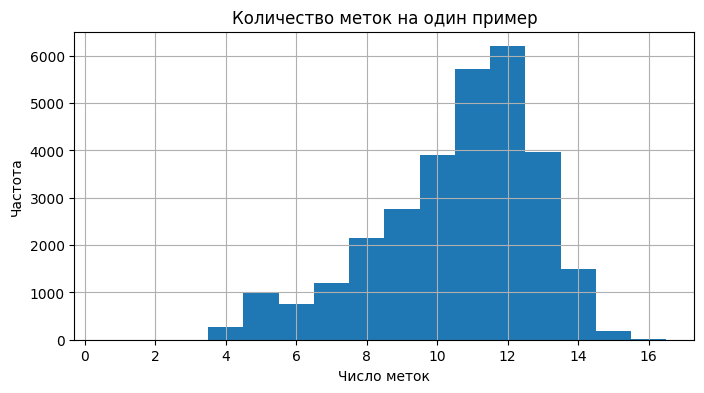

In [ ]:
# посчитаем количество меток на один текст
df['num_labels'] = df['label_vector'].apply(sum)

plt.figure(figsize=(8, 4))
df['num_labels'].hist(bins=range(1, df['num_labels'].max() + 2), align='left')
plt.title('Количество меток на один пример')
plt.xlabel('Число меток')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

График иллюстрирует распределение количества меток на один текст. Видно, что большинство текстов содержат от 9 до 13 меток, с пиком в районе 11–12. Распределение похоже на нормальное, но немного скошено вправо, что может указывать на наличие отдельных текстов с аномально большим количеством меток.


In [ ]:
text_column = 'text'
target_columns = [col for col in df.columns if col != text_column]
print(df.columns)

Index(['id', 'text', 'labels', 'label_vector', 'num_labels'], dtype='object')


In [ ]:
import random
for i in range(5):
    idx = random.randint(0, len(df) - 1)
    text = df.iloc[idx][text_column]
    labels = df.iloc[idx][target_columns]

    print(f"\nПример {i + 1}")
    print("Текст:")
    print(text[:1000])


Пример 1
Текст:
Невероятная комедия «Слишком женатый таксист»
🏛
ДК им. Зуева
🗓
06.09 (пт) в 19:00
🗓
13.09 (пт) в 19:00
🗓
21.09 (сб) в 19:00
🎫
Билеты по ссылке здесь
💚
-25% по промокоду ТИК
В ролях: Светлана Пермякова/Татьяна Афанасьева/Алина Ланина, Тимур Еремеев/Денис Косяков, Мирослава Карпович/Марина Соколова/Валерия Федорович, Александр Якин/Андрей Шугов/Михаил Башкатов, Антон Косточкин/Сергей Федюшкин и другие
История о простом таксисте, который каким-то образом умудрился стать двоеженцем. Герой спасает бабушку от бандитов и оказывается после этого в больнице. Там он удивляет докторов и называет два разных домашних адреса. Как же ему удастся выпутаться?
🥰
Билеты со скидками
@teatr_msk

Пример 2
Текст:
Фестиваль «Halloween Fest — Рейв-Медитация „Ашрам Кали“»
Масштабный фестиваль электронной музыки, искусства и творчества в клубе Gipsy перевернёт привычные представления о Хеллоуине. Этот уникальный проект объединяет Запад и Восток, современность и этнику, танцевальное и визуальное 

похоже, что тексты - афиши и описания мероприятий. Стиль подачи неформальный, часто с эмодзи, ссылками и элементами рекламного текста. Структура содержит название события, дату и место проведения и призыв купить билеты или перейти по ссылке

# Блок 2. Очистки текста

## 2.1 TF-IDF + нейросеть

Особенности:

- Токенизация простая, на уровне слов/символов

- Порядок слов не учитывается, только частотность

- Очистка должна быть сильной


Методы очистки:

- Привести к нижнему регистру

- Удалить пунктуацию

- Удалить числа, эмодзи, ссылки, спецсимволы

- Удалить стоп-слова

- Можно сделать лемматизацию или стемминг

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))
stemmer = SnowballStemmer('russian')

def clean_text_tfidf(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # ссылки
    text = re.sub(r'[^\w\s]', '', text)  # пунктуация
    text = re.sub(r'\d+', '', text)  # числа
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 2.2 Word2Vec + нейросеть


Особенности:
- Требует токенизации
- Контекст слов важен
- Лемматизация полезна, но не обязательна

In [ ]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("russian")

def clean_text_w2v(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)


## 2.3 Встроенный эмбеддинг + CNN

Особенности:
- Порядок слов имеет значение
- Лучше не удалять знаки препинания полностью
- Очистка мягче

In [ ]:
def clean_text_cnn(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


## 2.4  Встроенный эмбеддинг + RNN (LSTM/GRU)

Особенности:
- Очень чувствительно к порядку и структуре
- Лучше сохранить знаки препинания

In [ ]:
def clean_text_rnn(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
# тот же что и для cnn

## 2.5 BERT и другие Transformer-модели

Особенности:
- Модель сама обрабатывает casing, пунктуацию, эмодзи и прочее
- Лучше почти ничего не убирать, иначе можно ухудшить результат

In [ ]:
def clean_text_bert(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


## 2.6 применение

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
df['text_tfidf'] = df['text'].apply(clean_text_tfidf)
df['text_w2v'] = df['text'].apply(clean_text_w2v)
df['text_cnn'] = df['text'].apply(clean_text_cnn)
df['text_rnn'] = df['text'].apply(clean_text_rnn)
df['text_bert'] = df['text'].apply(clean_text_bert)


# Блок 3. Модели

## 3.1 train и val

In [ ]:
from sklearn.model_selection import train_test_split


target_columns = [f'label_{i}' for i in range(len(df['label_vector'].iloc[0]))]
df[target_columns] = pd.DataFrame(df['label_vector'].tolist(), index=df.index)
y = df[target_columns]



X = df['text']  # в общем случае, вообще типа 'text_tfidf'
y = df[target_columns]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
df[target_columns].head()

,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,label_9,label_10,label_11,label_12,label_13,label_14,label_15,label_16,label_17,label_18,label_19
0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,1,1,1,0,0,1
1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,1,1,0,0,1
2,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1
3,1,1,0,0,1,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0
4,1,1,0,0,0,0,0,1,1,0,0,1,1,1,1,0,1,1,1,0


## 3.2 Обучение моделей

### TF-IDF + простая нейросеть (MLP)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/40
------------------------------
Train Loss: 0.5588 | Val Loss: 0.4485 | Val F1: 0.6095
Сохраняем новую лучшую модель

Epoch 2/40
------------------------------
Train Loss: 0.4070 | Val Loss: 0.3760 | Val F1: 0.6591
Сохраняем новую лучшую модель

Epoch 3/40
------------------------------
Train Loss: 0.3531 | Val Loss: 0.3392 | Val F1: 0.6857
Сохраняем новую лучшую модель

Epoch 4/40
------------------------------
Train Loss: 0.3213 | Val Loss: 0.3149 | Val F1: 0.6957
Сохраняем новую лучшую модель

Epoch 5/40
------------------------------
Train Loss: 0.2984 | Val Loss: 0.2968 | Val F1: 0.7028
Сохраняем новую лучшую модель

Epoch 6/40
------------------------------
Train Loss: 0.2800 | Val Loss: 0.2826 | Val F1: 0.7138
Сохраняем новую лучшую модель

Epoch 7/40
------------------------------
Train Loss: 0.2655 | Val Loss: 0.2713 | Val F1: 0.7216
Сохраняем новую лучшую модель

Epoch 8/40
------------------------------
Train Loss: 0.2535 | Val Loss: 0.2620 | Val F1: 0.7315
Сохран

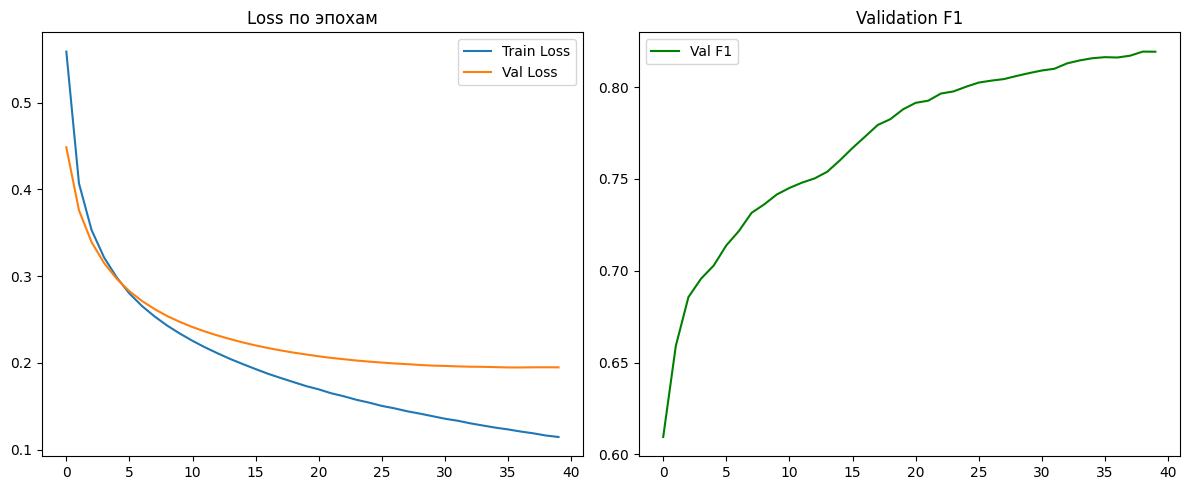

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import copy
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))
stemmer = SnowballStemmer('russian')


def clean_text_tfidf(text): # продублируем очистку, чтобы при необходимости можно было не запускать весь блокнот
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)


df['label_vector'] = df['labels'].apply(lambda x: list(map(int, x.strip().split())))
df['text_tfidf'] = df['text'].apply(clean_text_tfidf)

target_columns = [f'label_{i}' for i in range(len(df['label_vector'].iloc[0]))]
df[target_columns] = pd.DataFrame(df['label_vector'].tolist(), index=df.index)

tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf_vectorizer.fit_transform(df['text_tfidf'])
y = df[target_columns]

X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

class TfidfDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.toarray(), dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TfidfDataset(X_train, y_train)
val_dataset = TfidfDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLPClassifier(X_tfidf.shape[1], y.shape[1]).to(device)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None,
                num_epochs=40, patience=3, warmup_epochs=2, model_path='best_model.pt'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    patience_counter = 0

    train_losses, val_losses = [], []
    val_f1s = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        if scheduler and epoch < warmup_epochs:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-4

        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                preds = (outputs > 0.5).float().cpu().numpy()
                labels = targets.cpu().numpy()
                all_preds.append(preds)
                all_labels.append(labels)

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)
        f1 = f1_score(all_labels, all_preds, average='macro')
        val_f1s.append(f1)

        print(f"Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_loss:.4f} | Val F1: {f1:.4f}")

        if scheduler and epoch >= warmup_epochs:
            scheduler.step(val_loss)

        if f1 > best_f1:
            print("Сохраняем новую лучшую модель")
            best_f1 = f1
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), model_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Ранняя остановка")
                break

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title("Loss по эпохам")

    plt.subplot(1, 2, 2)
    plt.plot(val_f1s, label='Val F1', color='green')
    plt.legend()
    plt.title("Validation F1")

    plt.tight_layout()
    plt.show()

    model.load_state_dict(best_model_wts)
    return model

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

model = train_model(model, train_loader, val_loader, criterion, optimizer,
                    scheduler=scheduler,
                    num_epochs=40,
                    patience=3,
                    warmup_epochs=2,
                    model_path='mlp_tfidf_best.pt')


Переобучение не возникло, f1 достаточно неплохой!

### Word2Vec

In [ ]:
!pip install --upgrade numpy
!pip install --force-reinstall --no-cache-dir gensim


  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 14.4 MB/s eta 0:00:00
     ━━

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from gensim.models import Word2Vec
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import re

Epoch 1/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 667.90it/s]



Epoch 1/30
Train Loss: 0.5884 | Val Loss: 0.4454 | Val F1 (macro): 0.6881
🎉 New best model found!


Epoch 2/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 723.70it/s]



Epoch 2/30
Train Loss: 0.3703 | Val Loss: 0.3051 | Val F1 (macro): 0.7201
🎉 New best model found!


Epoch 3/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 954.77it/s]



Epoch 3/30
Train Loss: 0.3152 | Val Loss: 0.2835 | Val F1 (macro): 0.7274
🎉 New best model found!


Epoch 4/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 920.61it/s]



Epoch 4/30
Train Loss: 0.3026 | Val Loss: 0.2716 | Val F1 (macro): 0.7350
🎉 New best model found!


Epoch 5/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 945.17it/s]



Epoch 5/30
Train Loss: 0.2963 | Val Loss: 0.2647 | Val F1 (macro): 0.7403
🎉 New best model found!


Epoch 6/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 820.15it/s]



Epoch 6/30
Train Loss: 0.2913 | Val Loss: 0.2639 | Val F1 (macro): 0.7417
🎉 New best model found!


Epoch 7/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 832.84it/s]



Epoch 7/30
Train Loss: 0.2882 | Val Loss: 0.2570 | Val F1 (macro): 0.7445
🎉 New best model found!


Epoch 8/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 934.36it/s]



Epoch 8/30
Train Loss: 0.2850 | Val Loss: 0.2553 | Val F1 (macro): 0.7452
🎉 New best model found!


Epoch 9/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 890.08it/s]



Epoch 9/30
Train Loss: 0.2832 | Val Loss: 0.2528 | Val F1 (macro): 0.7455
🎉 New best model found!


Epoch 10/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 888.65it/s]



Epoch 10/30
Train Loss: 0.2800 | Val Loss: 0.2514 | Val F1 (macro): 0.7471
🎉 New best model found!


Epoch 11/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 905.76it/s]



Epoch 11/30
Train Loss: 0.2786 | Val Loss: 0.2496 | Val F1 (macro): 0.7464


Epoch 12/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 605.26it/s]



Epoch 12/30
Train Loss: 0.2755 | Val Loss: 0.2473 | Val F1 (macro): 0.7503
🎉 New best model found!


Epoch 13/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 660.48it/s]



Epoch 13/30
Train Loss: 0.2743 | Val Loss: 0.2469 | Val F1 (macro): 0.7475


Epoch 14/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 918.64it/s]



Epoch 14/30
Train Loss: 0.2729 | Val Loss: 0.2485 | Val F1 (macro): 0.7488


Epoch 15/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 893.00it/s]



Epoch 15/30
Train Loss: 0.2707 | Val Loss: 0.2439 | Val F1 (macro): 0.7491


Epoch 16/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 881.91it/s]



Epoch 16/30
Train Loss: 0.2705 | Val Loss: 0.2442 | Val F1 (macro): 0.7501


Epoch 17/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 930.84it/s]



Epoch 17/30
Train Loss: 0.2679 | Val Loss: 0.2412 | Val F1 (macro): 0.7507
🎉 New best model found!


Epoch 18/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 882.35it/s]



Epoch 18/30
Train Loss: 0.2664 | Val Loss: 0.2400 | Val F1 (macro): 0.7513
🎉 New best model found!


Epoch 19/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 865.64it/s]



Epoch 19/30
Train Loss: 0.2657 | Val Loss: 0.2392 | Val F1 (macro): 0.7512


Epoch 20/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 865.20it/s]



Epoch 20/30
Train Loss: 0.2646 | Val Loss: 0.2364 | Val F1 (macro): 0.7538
🎉 New best model found!


Epoch 21/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 807.60it/s]



Epoch 21/30
Train Loss: 0.2630 | Val Loss: 0.2363 | Val F1 (macro): 0.7538
🎉 New best model found!


Epoch 22/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 930.29it/s]



Epoch 22/30
Train Loss: 0.2626 | Val Loss: 0.2365 | Val F1 (macro): 0.7523


Epoch 23/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 587.37it/s]



Epoch 23/30
Train Loss: 0.2612 | Val Loss: 0.2340 | Val F1 (macro): 0.7535


Epoch 24/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 579.07it/s]



Epoch 24/30
Train Loss: 0.2608 | Val Loss: 0.2352 | Val F1 (macro): 0.7538
🎉 New best model found!


Epoch 25/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 788.15it/s]



Epoch 25/30
Train Loss: 0.2598 | Val Loss: 0.2359 | Val F1 (macro): 0.7532


Epoch 26/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 917.72it/s]



Epoch 26/30
Train Loss: 0.2599 | Val Loss: 0.2357 | Val F1 (macro): 0.7538


Epoch 27/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 871.82it/s]



Epoch 27/30
Train Loss: 0.2588 | Val Loss: 0.2338 | Val F1 (macro): 0.7535


Epoch 28/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 906.77it/s]



Epoch 28/30
Train Loss: 0.2586 | Val Loss: 0.2356 | Val F1 (macro): 0.7536


Epoch 29/30 - Validation: 100%|██████████| 93/93 [00:00<00:00, 913.77it/s]



Epoch 29/30
Train Loss: 0.2587 | Val Loss: 0.2346 | Val F1 (macro): 0.7535
🛑 Early stopping triggered at epoch 29


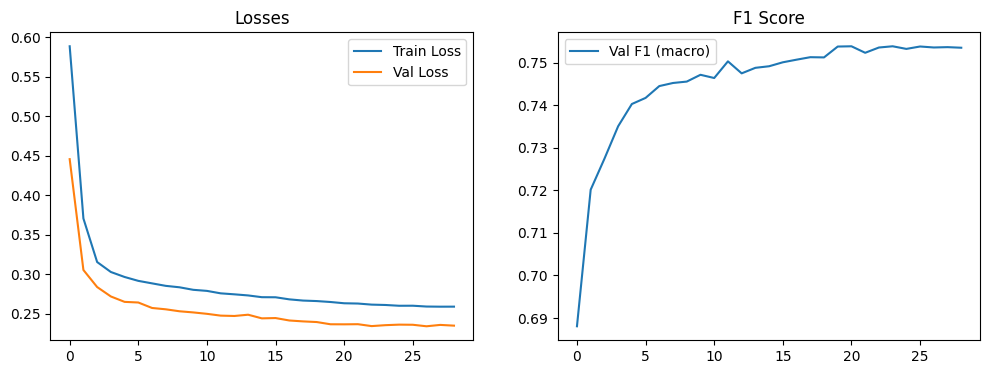

<All keys matched successfully>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from gensim.models import Word2Vec
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 30
BATCH_SIZE = 64
PATIENCE = 5
WARMUP_EPOCHS = 3
MODEL_PATH = "best_w2v_model.pt"
target_columns = y_train.columns.tolist()
NUM_CLASSES = len(target_columns)

def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

tokenized_train = [tokenize(text) for text in X_train]
tokenized_val = [tokenize(text) for text in X_val]

w2v_model = Word2Vec(sentences=tokenized_train, vector_size=300, window=5, min_count=2, workers=4)
embedding_dim = w2v_model.vector_size

def get_average_vector(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

X_train_w2v = np.array([get_average_vector(tokens, w2v_model) for tokens in tokenized_train])
X_val_w2v = np.array([get_average_vector(tokens, w2v_model) for tokens in tokenized_val])

class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TextDataset(X_train_w2v, y_train)
val_dataset = TextDataset(X_val_w2v, y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

class Word2VecNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, output_dim),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

model = Word2VecNet(input_dim=embedding_dim, output_dim=NUM_CLASSES).to(device)

criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS,
    pct_start=WARMUP_EPOCHS/EPOCHS
)

train_losses, val_losses, val_f1s = [], [], []
best_f1 = 0
epochs_no_improve = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)

    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    val_loss /= len(val_loader)
    preds = np.vstack(all_preds) > 0.5
    targets = np.vstack(all_labels)
    val_f1 = f1_score(targets, preds, average='macro')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_f1s.append(val_f1)

    print(f"\nEpoch {epoch}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1 (macro): {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), MODEL_PATH)
        print("Сохраняем новую лучшую модель")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Ранняя остановка")
            break

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss по эпохам')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_f1s, label='Val F1 (macro)')
plt.title('F1 Score')
plt.legend()
plt.show()

model.load_state_dict(torch.load(MODEL_PATH))

Ранняя остановка сработала на 29 эпохе из 30, к этому моменту модель уже уперлась в потолок, это можно видеть на графике f1. графики val и train loss не показывают переобучение, но они тоже достигли своих минимумов. В итоге f1 составил 75%, но переобучения нет

### CNN

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 645.28it/s]



Epoch 1/100
Train Loss: 0.5533 | Val Loss: 0.4056 | Val F1 (macro): 0.6379
🎉 New best model found!


Epoch 2/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 534.66it/s]



Epoch 2/100
Train Loss: 0.3909 | Val Loss: 0.3432 | Val F1 (macro): 0.6903
🎉 New best model found!


Epoch 3/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 610.60it/s]



Epoch 3/100
Train Loss: 0.3596 | Val Loss: 0.3299 | Val F1 (macro): 0.6922
🎉 New best model found!


Epoch 4/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 672.52it/s]



Epoch 4/100
Train Loss: 0.3489 | Val Loss: 0.3235 | Val F1 (macro): 0.6928
🎉 New best model found!


Epoch 5/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 616.39it/s]



Epoch 5/100
Train Loss: 0.3397 | Val Loss: 0.3173 | Val F1 (macro): 0.6941
🎉 New best model found!


Epoch 6/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 664.23it/s]



Epoch 6/100
Train Loss: 0.3323 | Val Loss: 0.3114 | Val F1 (macro): 0.6952
🎉 New best model found!


Epoch 7/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 496.49it/s]



Epoch 7/100
Train Loss: 0.3247 | Val Loss: 0.3050 | Val F1 (macro): 0.6975
🎉 New best model found!


Epoch 8/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 650.92it/s]



Epoch 8/100
Train Loss: 0.3166 | Val Loss: 0.2987 | Val F1 (macro): 0.7003
🎉 New best model found!


Epoch 9/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 668.40it/s]



Epoch 9/100
Train Loss: 0.3103 | Val Loss: 0.2923 | Val F1 (macro): 0.7020
🎉 New best model found!


Epoch 10/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 650.86it/s]



Epoch 10/100
Train Loss: 0.3045 | Val Loss: 0.2864 | Val F1 (macro): 0.7042
🎉 New best model found!


Epoch 11/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 666.99it/s]



Epoch 11/100
Train Loss: 0.2994 | Val Loss: 0.2826 | Val F1 (macro): 0.7055
🎉 New best model found!


Epoch 12/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 480.09it/s]



Epoch 12/100
Train Loss: 0.2951 | Val Loss: 0.2803 | Val F1 (macro): 0.7069
🎉 New best model found!


Epoch 13/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 651.83it/s]



Epoch 13/100
Train Loss: 0.2919 | Val Loss: 0.2772 | Val F1 (macro): 0.7062


Epoch 14/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 655.95it/s]



Epoch 14/100
Train Loss: 0.2891 | Val Loss: 0.2751 | Val F1 (macro): 0.7071
🎉 New best model found!


Epoch 15/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 661.34it/s]



Epoch 15/100
Train Loss: 0.2867 | Val Loss: 0.2738 | Val F1 (macro): 0.7077
🎉 New best model found!


Epoch 16/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 535.22it/s]



Epoch 16/100
Train Loss: 0.2844 | Val Loss: 0.2711 | Val F1 (macro): 0.7091
🎉 New best model found!


Epoch 17/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 605.85it/s]



Epoch 17/100
Train Loss: 0.2820 | Val Loss: 0.2713 | Val F1 (macro): 0.7098
🎉 New best model found!


Epoch 18/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 657.38it/s]



Epoch 18/100
Train Loss: 0.2803 | Val Loss: 0.2690 | Val F1 (macro): 0.7100
🎉 New best model found!


Epoch 19/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 660.15it/s]



Epoch 19/100
Train Loss: 0.2787 | Val Loss: 0.2671 | Val F1 (macro): 0.7115
🎉 New best model found!


Epoch 20/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 637.92it/s]



Epoch 20/100
Train Loss: 0.2765 | Val Loss: 0.2651 | Val F1 (macro): 0.7119
🎉 New best model found!


Epoch 21/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 478.15it/s]



Epoch 21/100
Train Loss: 0.2744 | Val Loss: 0.2632 | Val F1 (macro): 0.7141
🎉 New best model found!


Epoch 22/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 605.69it/s]



Epoch 22/100
Train Loss: 0.2725 | Val Loss: 0.2621 | Val F1 (macro): 0.7140


Epoch 23/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 655.33it/s]



Epoch 23/100
Train Loss: 0.2705 | Val Loss: 0.2617 | Val F1 (macro): 0.7142
🎉 New best model found!


Epoch 24/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 621.43it/s]



Epoch 24/100
Train Loss: 0.2689 | Val Loss: 0.2592 | Val F1 (macro): 0.7162
🎉 New best model found!


Epoch 25/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 650.27it/s]



Epoch 25/100
Train Loss: 0.2673 | Val Loss: 0.2579 | Val F1 (macro): 0.7160


Epoch 26/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 550.24it/s]



Epoch 26/100
Train Loss: 0.2652 | Val Loss: 0.2562 | Val F1 (macro): 0.7169
🎉 New best model found!


Epoch 27/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 651.53it/s]



Epoch 27/100
Train Loss: 0.2637 | Val Loss: 0.2565 | Val F1 (macro): 0.7157


Epoch 28/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 651.82it/s]



Epoch 28/100
Train Loss: 0.2624 | Val Loss: 0.2537 | Val F1 (macro): 0.7170
🎉 New best model found!


Epoch 29/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 656.24it/s]



Epoch 29/100
Train Loss: 0.2609 | Val Loss: 0.2527 | Val F1 (macro): 0.7167


Epoch 30/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 661.47it/s]



Epoch 30/100
Train Loss: 0.2587 | Val Loss: 0.2507 | Val F1 (macro): 0.7176
🎉 New best model found!


Epoch 31/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 519.68it/s]



Epoch 31/100
Train Loss: 0.2574 | Val Loss: 0.2507 | Val F1 (macro): 0.7173


Epoch 32/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 611.50it/s]



Epoch 32/100
Train Loss: 0.2559 | Val Loss: 0.2500 | Val F1 (macro): 0.7175


Epoch 33/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 640.43it/s]



Epoch 33/100
Train Loss: 0.2555 | Val Loss: 0.2482 | Val F1 (macro): 0.7184
🎉 New best model found!


Epoch 34/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 647.51it/s]



Epoch 34/100
Train Loss: 0.2534 | Val Loss: 0.2480 | Val F1 (macro): 0.7187
🎉 New best model found!


Epoch 35/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 661.46it/s]



Epoch 35/100
Train Loss: 0.2523 | Val Loss: 0.2468 | Val F1 (macro): 0.7191
🎉 New best model found!


Epoch 36/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 415.03it/s]



Epoch 36/100
Train Loss: 0.2521 | Val Loss: 0.2461 | Val F1 (macro): 0.7200
🎉 New best model found!


Epoch 37/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 624.58it/s]



Epoch 37/100
Train Loss: 0.2512 | Val Loss: 0.2463 | Val F1 (macro): 0.7185


Epoch 38/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 626.08it/s]



Epoch 38/100
Train Loss: 0.2494 | Val Loss: 0.2450 | Val F1 (macro): 0.7193


Epoch 39/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 598.90it/s]



Epoch 39/100
Train Loss: 0.2488 | Val Loss: 0.2454 | Val F1 (macro): 0.7193


Epoch 40/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 427.65it/s]



Epoch 40/100
Train Loss: 0.2474 | Val Loss: 0.2435 | Val F1 (macro): 0.7200


Epoch 41/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 608.97it/s]



Epoch 41/100
Train Loss: 0.2466 | Val Loss: 0.2429 | Val F1 (macro): 0.7208
🎉 New best model found!


Epoch 42/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 610.94it/s]



Epoch 42/100
Train Loss: 0.2459 | Val Loss: 0.2431 | Val F1 (macro): 0.7200


Epoch 43/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 646.10it/s]



Epoch 43/100
Train Loss: 0.2449 | Val Loss: 0.2428 | Val F1 (macro): 0.7207


Epoch 44/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 594.57it/s]



Epoch 44/100
Train Loss: 0.2447 | Val Loss: 0.2414 | Val F1 (macro): 0.7206


Epoch 45/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 470.31it/s]



Epoch 45/100
Train Loss: 0.2426 | Val Loss: 0.2412 | Val F1 (macro): 0.7210
🎉 New best model found!


Epoch 46/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 657.51it/s]



Epoch 46/100
Train Loss: 0.2421 | Val Loss: 0.2407 | Val F1 (macro): 0.7213
🎉 New best model found!


Epoch 47/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 627.01it/s]



Epoch 47/100
Train Loss: 0.2415 | Val Loss: 0.2401 | Val F1 (macro): 0.7212


Epoch 48/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 653.58it/s]



Epoch 48/100
Train Loss: 0.2412 | Val Loss: 0.2407 | Val F1 (macro): 0.7206


Epoch 49/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 610.62it/s]



Epoch 49/100
Train Loss: 0.2403 | Val Loss: 0.2395 | Val F1 (macro): 0.7207


Epoch 50/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 524.01it/s]



Epoch 50/100
Train Loss: 0.2396 | Val Loss: 0.2390 | Val F1 (macro): 0.7215
🎉 New best model found!


Epoch 51/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 640.95it/s]



Epoch 51/100
Train Loss: 0.2383 | Val Loss: 0.2389 | Val F1 (macro): 0.7216
🎉 New best model found!


Epoch 52/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 650.89it/s]



Epoch 52/100
Train Loss: 0.2376 | Val Loss: 0.2379 | Val F1 (macro): 0.7225
🎉 New best model found!


Epoch 53/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 656.97it/s]



Epoch 53/100
Train Loss: 0.2369 | Val Loss: 0.2381 | Val F1 (macro): 0.7212


Epoch 54/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 617.98it/s]



Epoch 54/100
Train Loss: 0.2358 | Val Loss: 0.2371 | Val F1 (macro): 0.7222


Epoch 55/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 574.79it/s]



Epoch 55/100
Train Loss: 0.2356 | Val Loss: 0.2371 | Val F1 (macro): 0.7220


Epoch 56/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 176.86it/s]



Epoch 56/100
Train Loss: 0.2347 | Val Loss: 0.2367 | Val F1 (macro): 0.7226
🎉 New best model found!


Epoch 57/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 638.11it/s]



Epoch 57/100
Train Loss: 0.2347 | Val Loss: 0.2368 | Val F1 (macro): 0.7226


Epoch 58/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 640.50it/s]



Epoch 58/100
Train Loss: 0.2330 | Val Loss: 0.2361 | Val F1 (macro): 0.7227
🎉 New best model found!


Epoch 59/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 536.13it/s]



Epoch 59/100
Train Loss: 0.2322 | Val Loss: 0.2359 | Val F1 (macro): 0.7226


Epoch 60/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 596.82it/s]



Epoch 60/100
Train Loss: 0.2318 | Val Loss: 0.2351 | Val F1 (macro): 0.7228
🎉 New best model found!


Epoch 61/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 633.57it/s]



Epoch 61/100
Train Loss: 0.2308 | Val Loss: 0.2345 | Val F1 (macro): 0.7234
🎉 New best model found!


Epoch 62/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 649.08it/s]



Epoch 62/100
Train Loss: 0.2303 | Val Loss: 0.2346 | Val F1 (macro): 0.7238
🎉 New best model found!


Epoch 63/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 634.11it/s]



Epoch 63/100
Train Loss: 0.2294 | Val Loss: 0.2357 | Val F1 (macro): 0.7238


Epoch 64/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 481.59it/s]



Epoch 64/100
Train Loss: 0.2290 | Val Loss: 0.2339 | Val F1 (macro): 0.7244
🎉 New best model found!


Epoch 65/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 588.80it/s]



Epoch 65/100
Train Loss: 0.2283 | Val Loss: 0.2346 | Val F1 (macro): 0.7241


Epoch 66/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 648.37it/s]



Epoch 66/100
Train Loss: 0.2278 | Val Loss: 0.2347 | Val F1 (macro): 0.7237


Epoch 67/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 629.25it/s]



Epoch 67/100
Train Loss: 0.2268 | Val Loss: 0.2359 | Val F1 (macro): 0.7243


Epoch 68/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 650.38it/s]



Epoch 68/100
Train Loss: 0.2257 | Val Loss: 0.2354 | Val F1 (macro): 0.7244
🎉 New best model found!


Epoch 69/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 521.97it/s]



Epoch 69/100
Train Loss: 0.2256 | Val Loss: 0.2335 | Val F1 (macro): 0.7244


Epoch 70/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 589.34it/s]



Epoch 70/100
Train Loss: 0.2251 | Val Loss: 0.2347 | Val F1 (macro): 0.7245
🎉 New best model found!


Epoch 71/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 653.75it/s]



Epoch 71/100
Train Loss: 0.2249 | Val Loss: 0.2340 | Val F1 (macro): 0.7243


Epoch 72/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 596.14it/s]



Epoch 72/100
Train Loss: 0.2247 | Val Loss: 0.2340 | Val F1 (macro): 0.7249
🎉 New best model found!


Epoch 73/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 651.28it/s]



Epoch 73/100
Train Loss: 0.2245 | Val Loss: 0.2337 | Val F1 (macro): 0.7252
🎉 New best model found!


Epoch 74/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 488.74it/s]



Epoch 74/100
Train Loss: 0.2237 | Val Loss: 0.2329 | Val F1 (macro): 0.7248


Epoch 75/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 591.16it/s]



Epoch 75/100
Train Loss: 0.2234 | Val Loss: 0.2337 | Val F1 (macro): 0.7248


Epoch 76/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 649.05it/s]



Epoch 76/100
Train Loss: 0.2237 | Val Loss: 0.2341 | Val F1 (macro): 0.7253
🎉 New best model found!


Epoch 77/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 602.08it/s]



Epoch 77/100
Train Loss: 0.2237 | Val Loss: 0.2334 | Val F1 (macro): 0.7251


Epoch 78/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 655.40it/s]



Epoch 78/100
Train Loss: 0.2227 | Val Loss: 0.2339 | Val F1 (macro): 0.7247


Epoch 79/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 468.67it/s]



Epoch 79/100
Train Loss: 0.2229 | Val Loss: 0.2335 | Val F1 (macro): 0.7250


Epoch 80/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 648.45it/s]



Epoch 80/100
Train Loss: 0.2227 | Val Loss: 0.2333 | Val F1 (macro): 0.7253
🎉 New best model found!


Epoch 81/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 642.01it/s]



Epoch 81/100
Train Loss: 0.2224 | Val Loss: 0.2334 | Val F1 (macro): 0.7250


Epoch 82/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 637.79it/s]



Epoch 82/100
Train Loss: 0.2230 | Val Loss: 0.2340 | Val F1 (macro): 0.7253
🎉 New best model found!


Epoch 83/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 540.97it/s]



Epoch 83/100
Train Loss: 0.2218 | Val Loss: 0.2340 | Val F1 (macro): 0.7253
🎉 New best model found!


Epoch 84/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 639.78it/s]



Epoch 84/100
Train Loss: 0.2218 | Val Loss: 0.2342 | Val F1 (macro): 0.7248


Epoch 85/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 655.12it/s]



Epoch 85/100
Train Loss: 0.2229 | Val Loss: 0.2340 | Val F1 (macro): 0.7254
🎉 New best model found!


Epoch 86/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 642.66it/s]



Epoch 86/100
Train Loss: 0.2227 | Val Loss: 0.2341 | Val F1 (macro): 0.7251


Epoch 87/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 599.81it/s]



Epoch 87/100
Train Loss: 0.2232 | Val Loss: 0.2335 | Val F1 (macro): 0.7252


Epoch 88/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 480.25it/s]



Epoch 88/100
Train Loss: 0.2220 | Val Loss: 0.2340 | Val F1 (macro): 0.7253


Epoch 89/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 633.68it/s]



Epoch 89/100
Train Loss: 0.2227 | Val Loss: 0.2334 | Val F1 (macro): 0.7252


Epoch 90/100 - Validation: 100%|██████████| 93/93 [00:00<00:00, 644.37it/s]



Epoch 90/100
Train Loss: 0.2216 | Val Loss: 0.2340 | Val F1 (macro): 0.7254
🛑 Early stopping triggered.


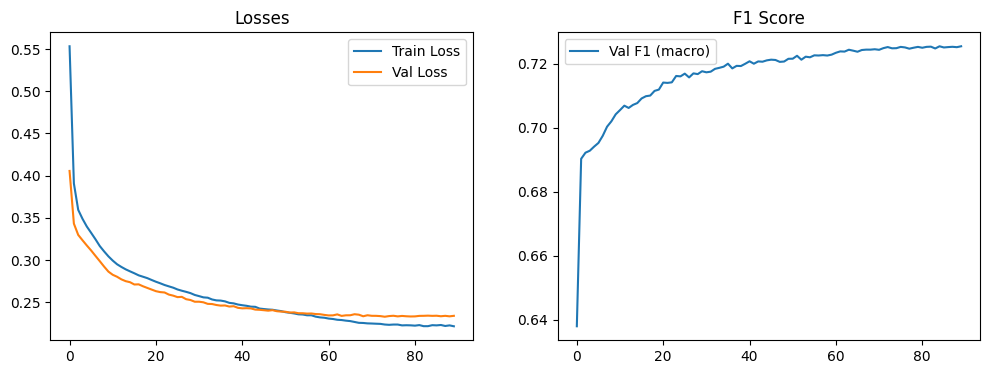

<All keys matched successfully>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import re
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 100
BATCH_SIZE = 64
PATIENCE = 5
MODEL_PATH = "best_cnn_model.pt"
WARMUP_EPOCHS = 3
target_columns = y_train.columns.tolist()
NUM_CLASSES = len(target_columns)
MAX_LEN = 200
EMBEDDING_DIM = 100

def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

tokenized_train = [tokenize(text) for text in df.loc[X_train.index, 'text_cnn']]
tokenized_val = [tokenize(text) for text in df.loc[X_val.index, 'text_cnn']]

all_tokens = [token for sentence in tokenized_train for token in sentence]
vocab = {"<PAD>": 0, "<UNK>": 1}
for token, count in Counter(all_tokens).items():
    if count >= 2:
        vocab[token] = len(vocab)

def encode(tokens, vocab, max_len=MAX_LEN):
    ids = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
    if len(ids) < max_len:
        ids += [vocab["<PAD>"]] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

X_train_encoded = [encode(tokens, vocab) for tokens in tokenized_train]
X_val_encoded = [encode(tokens, vocab) for tokens in tokenized_val]

class TextDatasetCNN(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TextDatasetCNN(X_train_encoded, y_train)
val_dataset = TextDatasetCNN(X_val_encoded, y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

class CNNTextClassifierImproved(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        self.conv_block = nn.Sequential(
            nn.Conv1d(embedding_dim, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Conv1d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.AdaptiveAvgPool1d(1)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(1, 2)
        x = self.conv_block(x)
        out = self.classifier(x)
        return out

model = CNNTextClassifierImproved(vocab_size=len(vocab), embedding_dim=EMBEDDING_DIM, output_dim=NUM_CLASSES).to(device)

criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

train_losses, val_losses, val_f1s = [], [], []
best_f1 = 0
epochs_no_improve = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)

    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    val_loss /= len(val_loader)
    preds = np.vstack(all_preds) > 0.5
    targets = np.vstack(all_labels)
    val_f1 = f1_score(targets, preds, average='macro')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_f1s.append(val_f1)

    print(f"\nEpoch {epoch}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1 (macro): {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), MODEL_PATH)
        print("🎉 New best model found!")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epoch > WARMUP_EPOCHS and epochs_no_improve >= PATIENCE:
            print("🛑 Early stopping triggered.")
            break

    scheduler.step(val_loss)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_f1s, label='Val F1 (macro)')
plt.title('F1 Score')
plt.legend()
plt.show()

model.load_state_dict(torch.load(MODEL_PATH))

эта модель обучалась стабильно, без переобучения, f1 немного улучшался, поэтому я увеличила число эпох до 100. в итоге f1 не очень высокий, поэтому далее я попробовала улучшить его

я попробовала позапускать модель с разными изменениями, в итоге пришла к этому:
- вместо обычной CNN я сделала модель, которая использует сразу несколько свёрток с разными размерами kernel_sizes = [3, 4, 5]
- после каждой свёртки я добавила AdaptiveMaxPool1d(1)
- вместо обычного BCELoss теперь использую BCEWithLogitsLoss, потому что он сразу включает в себя сигмоиду, это стабилизирует обучение
- для управления скоростью обучения использую OneCycleLR, он сам регулирует learning rate во время тренировки

Validating: 100%|██████████| 93/93 [00:00<00:00, 538.92it/s]



Epoch 1 | Train Loss: 0.6880 | Val Loss: 0.4505 | Val F1: 0.5907
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 394.72it/s]



Epoch 2 | Train Loss: 0.5369 | Val Loss: 0.3922 | Val F1: 0.6382
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 417.55it/s]



Epoch 3 | Train Loss: 0.4316 | Val Loss: 0.3456 | Val F1: 0.6970
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 402.57it/s]



Epoch 4 | Train Loss: 0.3745 | Val Loss: 0.3212 | Val F1: 0.7145
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 403.12it/s]



Epoch 5 | Train Loss: 0.3458 | Val Loss: 0.3003 | Val F1: 0.7253
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 565.75it/s]



Epoch 6 | Train Loss: 0.3272 | Val Loss: 0.2846 | Val F1: 0.7353
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 567.00it/s]



Epoch 7 | Train Loss: 0.3097 | Val Loss: 0.2738 | Val F1: 0.7389
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 553.94it/s]



Epoch 8 | Train Loss: 0.2968 | Val Loss: 0.2639 | Val F1: 0.7436
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 562.52it/s]



Epoch 9 | Train Loss: 0.2844 | Val Loss: 0.2565 | Val F1: 0.7442
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 566.76it/s]



Epoch 10 | Train Loss: 0.2731 | Val Loss: 0.2504 | Val F1: 0.7511
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 559.58it/s]



Epoch 11 | Train Loss: 0.2647 | Val Loss: 0.2462 | Val F1: 0.7595
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 562.79it/s]



Epoch 12 | Train Loss: 0.2564 | Val Loss: 0.2425 | Val F1: 0.7493


Validating: 100%|██████████| 93/93 [00:00<00:00, 554.18it/s]



Epoch 13 | Train Loss: 0.2504 | Val Loss: 0.2421 | Val F1: 0.7580


Validating: 100%|██████████| 93/93 [00:00<00:00, 550.76it/s]



Epoch 14 | Train Loss: 0.2458 | Val Loss: 0.2382 | Val F1: 0.7621
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 559.37it/s]



Epoch 15 | Train Loss: 0.2417 | Val Loss: 0.2359 | Val F1: 0.7632
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 530.84it/s]



Epoch 16 | Train Loss: 0.2393 | Val Loss: 0.2345 | Val F1: 0.7628


Validating: 100%|██████████| 93/93 [00:00<00:00, 578.66it/s]



Epoch 17 | Train Loss: 0.2365 | Val Loss: 0.2348 | Val F1: 0.7631


Validating: 100%|██████████| 93/93 [00:00<00:00, 564.64it/s]



Epoch 18 | Train Loss: 0.2347 | Val Loss: 0.2335 | Val F1: 0.7649
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 573.28it/s]



Epoch 19 | Train Loss: 0.2340 | Val Loss: 0.2339 | Val F1: 0.7642


Validating: 100%|██████████| 93/93 [00:00<00:00, 386.26it/s]



Epoch 20 | Train Loss: 0.2344 | Val Loss: 0.2343 | Val F1: 0.7648


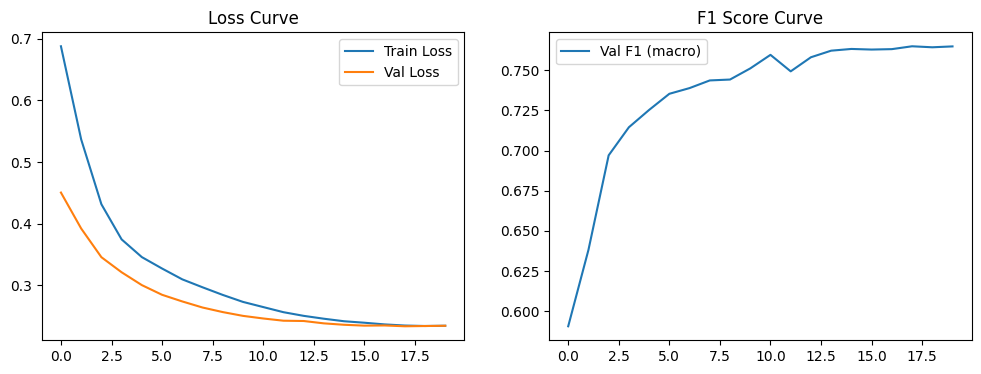

<All keys matched successfully>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 20
BATCH_SIZE = 64
PATIENCE = 5
MODEL_PATH = "best_cnn_model.pt"
MAX_LEN = 100
EMBEDDING_DIM = 128
LR = 1e-3
target_columns = y_train.columns.tolist()
NUM_CLASSES = len(target_columns)

def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

tokenized_train = [tokenize(text)[:MAX_LEN] for text in X_train]
tokenized_val = [tokenize(text)[:MAX_LEN] for text in X_val]

vocab = {"<PAD>": 0, "<UNK>": 1}
for sentence in tokenized_train:
    for token in sentence:
        if token not in vocab:
            vocab[token] = len(vocab)

def encode(tokens):
    ids = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
    return ids[:MAX_LEN] + [0] * (MAX_LEN - len(ids))

X_train_ids = np.array([encode(tokens) for tokens in tokenized_train])
X_val_ids = np.array([encode(tokens) for tokens in tokenized_val])

class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TextDataset(X_train_ids, y_train)
val_dataset = TextDataset(X_val_ids, y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

class CNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, output_dim, kernel_sizes=[3, 4, 5], num_filters=64, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.embed_dropout = nn.Dropout(0.3)
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(embed_dim, num_filters, ks),
                nn.BatchNorm1d(num_filters),
                nn.ReLU(),
                nn.AdaptiveMaxPool1d(1)
            ) for ks in kernel_sizes
        ])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), output_dim)

    def forward(self, x):
        x = self.embedding(x).transpose(1, 2)
        x = self.embed_dropout(x)
        x = [conv(x).squeeze(2) for conv in self.convs]
        x = torch.cat(x, dim=1)
        x = self.dropout(x)
        return self.fc(x)

model = CNNTextClassifier(vocab_size=len(vocab), embed_dim=EMBEDDING_DIM, output_dim=NUM_CLASSES).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, steps_per_epoch=len(train_loader), epochs=EPOCHS)

train_losses, val_losses, val_f1s = [], [], []
best_f1 = 0
epochs_no_improve = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} - Train"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)

    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            all_preds.append(torch.sigmoid(outputs).cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    val_loss /= len(val_loader)
    preds = np.vstack(all_preds) > 0.5
    targets = np.vstack(all_labels)
    val_f1 = f1_score(targets, preds, average='macro')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_f1s.append(val_f1)

    print(f"\nEpoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), MODEL_PATH)
        print("✅ New best model saved.")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("🛑 Early stopping.")
            break

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_f1s, label='Val F1 (macro)')
plt.title('F1 Score Curve')
plt.legend()
plt.show()

model.load_state_dict(torch.load(MODEL_PATH))

результаты все еще стабильные, f1 стал выше

In [ ]:
pip install scikit-multilearn iterative-stratification

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 3.5 MB/s eta 0:00:00


 ### RNN


Validating: 100%|██████████| 93/93 [00:00<00:00, 393.44it/s]



Epoch 1 | Train Loss: 0.6077 | Val Loss: 0.4983 | Val F1: 0.5409
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 323.49it/s]



Epoch 2 | Train Loss: 0.5046 | Val Loss: 0.4945 | Val F1: 0.5409
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 388.69it/s]



Epoch 3 | Train Loss: 0.4684 | Val Loss: 0.3468 | Val F1: 0.6636
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 383.39it/s]



Epoch 4 | Train Loss: 0.3372 | Val Loss: 0.3195 | Val F1: 0.6921
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 385.28it/s]



Epoch 5 | Train Loss: 0.3234 | Val Loss: 0.3144 | Val F1: 0.6905


Validating: 100%|██████████| 93/93 [00:00<00:00, 314.38it/s]



Epoch 6 | Train Loss: 0.3173 | Val Loss: 0.3112 | Val F1: 0.6926
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 384.60it/s]



Epoch 7 | Train Loss: 0.3108 | Val Loss: 0.3055 | Val F1: 0.6934
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 385.20it/s]



Epoch 8 | Train Loss: 0.2983 | Val Loss: 0.2908 | Val F1: 0.7024
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 389.36it/s]



Epoch 9 | Train Loss: 0.2794 | Val Loss: 0.2773 | Val F1: 0.7096
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 376.59it/s]



Epoch 10 | Train Loss: 0.2671 | Val Loss: 0.2648 | Val F1: 0.7307
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 384.37it/s]



Epoch 11 | Train Loss: 0.2529 | Val Loss: 0.2554 | Val F1: 0.7348
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 382.98it/s]



Epoch 12 | Train Loss: 0.2417 | Val Loss: 0.2508 | Val F1: 0.7451
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 341.62it/s]



Epoch 13 | Train Loss: 0.2338 | Val Loss: 0.2468 | Val F1: 0.7458
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 378.75it/s]



Epoch 14 | Train Loss: 0.2269 | Val Loss: 0.2453 | Val F1: 0.7475
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 383.56it/s]



Epoch 15 | Train Loss: 0.2208 | Val Loss: 0.2428 | Val F1: 0.7477
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 384.83it/s]



Epoch 16 | Train Loss: 0.2161 | Val Loss: 0.2431 | Val F1: 0.7491
✅ New best model saved.


Validating: 100%|██████████| 93/93 [00:00<00:00, 332.48it/s]



Epoch 17 | Train Loss: 0.2129 | Val Loss: 0.2427 | Val F1: 0.7476


Validating: 100%|██████████| 93/93 [00:00<00:00, 380.07it/s]



Epoch 18 | Train Loss: 0.2100 | Val Loss: 0.2430 | Val F1: 0.7483


Validating: 100%|██████████| 93/93 [00:00<00:00, 383.54it/s]



Epoch 19 | Train Loss: 0.2089 | Val Loss: 0.2425 | Val F1: 0.7486


Validating: 100%|██████████| 93/93 [00:00<00:00, 380.65it/s]



Epoch 20 | Train Loss: 0.2087 | Val Loss: 0.2425 | Val F1: 0.7485


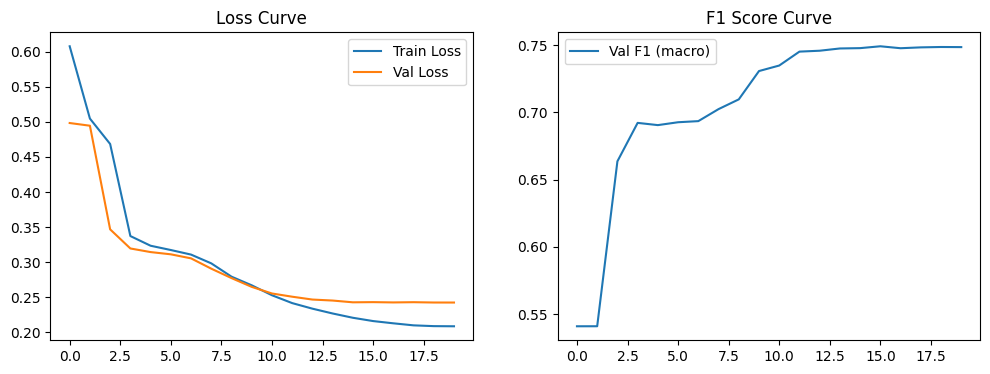

<All keys matched successfully>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import re
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 20
BATCH_SIZE = 64
PATIENCE = 5
MODEL_PATH = "best_rnn_model.pt"
MAX_LEN = 200
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
NUM_LAYERS = 1
DROPOUT = 0.5
LR = 1e-3

target_columns = y_train.columns.tolist()
NUM_CLASSES = len(target_columns)

def clean_text_rnn(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

tokenized_train = [tokenize(text) for text in df.loc[X_train.index, 'text_rnn']]
tokenized_val = [tokenize(text) for text in df.loc[X_val.index, 'text_rnn']]

all_tokens = [token for sentence in tokenized_train for token in sentence]
vocab = {"<PAD>": 0, "<UNK>": 1}
for token, count in Counter(all_tokens).items():
    if count >= 2:
        vocab[token] = len(vocab)

def encode(tokens, vocab, max_len=MAX_LEN):
    ids = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
    if len(ids) < max_len:
        ids += [vocab["<PAD>"]] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

X_train_encoded = [encode(tokens, vocab) for tokens in tokenized_train]
X_val_encoded = [encode(tokens, vocab) for tokens in tokenized_val]

class TextDatasetRNN(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TextDatasetRNN(X_train_encoded, y_train)
val_dataset = TextDatasetRNN(X_val_encoded, y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

class RNNTextClassifierImproved(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, _) = self.rnn(embedded)
        out = self.dropout(hidden[-1])
        return self.fc(out)

model = RNNTextClassifierImproved(vocab_size=len(vocab),
                                  embedding_dim=EMBEDDING_DIM,
                                  hidden_dim=HIDDEN_DIM,
                                  output_dim=NUM_CLASSES,
                                  num_layers=NUM_LAYERS,
                                  dropout=DROPOUT).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                          steps_per_epoch=len(train_loader), epochs=EPOCHS)

train_losses, val_losses, val_f1s = [], [], []
best_f1 = 0
epochs_no_improve = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} - Train"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)

    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            all_preds.append(torch.sigmoid(outputs).cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    val_loss /= len(val_loader)
    preds = np.vstack(all_preds) > 0.5
    targets = np.vstack(all_labels)
    val_f1 = f1_score(targets, preds, average='macro')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_f1s.append(val_f1)

    print(f"\nEpoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), MODEL_PATH)
        print("✅ New best model saved.")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("🛑 Early stopping.")
            break

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_f1s, label='Val F1 (macro)')
plt.title('F1 Score Curve')
plt.legend()
plt.show()

model.load_state_dict(torch.load(MODEL_PATH))

### BERT

In [ ]:
!pip install -q transformers datasets scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12

Использовала модель DeepPavlov/rubert-base-cased, потому что она хорошо работает с текстами на русском языке

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing Bert

Epoch 1 | Train Loss: 0.2825 | Val Loss: 0.2153 | Val F1: 0.7680
✅ Best model saved to:
 - best_bert_model.pt
 - /content/drive/MyDrive/best_bert_model.pt


Epoch 2: 100%|██████████| 1479/1479 [09:08<00:00,  2.70it/s]


Epoch 2 | Train Loss: 0.1890 | Val Loss: 0.1678 | Val F1: 0.7986
✅ Best model saved to:
 - best_bert_model.pt
 - /content/drive/MyDrive/best_bert_model.pt


Epoch 3: 100%|██████████| 1479/1479 [09:08<00:00,  2.69it/s]


Epoch 3 | Train Loss: 0.1399 | Val Loss: 0.1483 | Val F1: 0.8105
✅ Best model saved to:
 - best_bert_model.pt
 - /content/drive/MyDrive/best_bert_model.pt


Epoch 4: 100%|██████████| 1479/1479 [09:08<00:00,  2.70it/s]


Epoch 4 | Train Loss: 0.1097 | Val Loss: 0.1434 | Val F1: 0.8227
✅ Best model saved to:
 - best_bert_model.pt
 - /content/drive/MyDrive/best_bert_model.pt


Epoch 5: 100%|██████████| 1479/1479 [09:08<00:00,  2.69it/s]


Epoch 5 | Train Loss: 0.0901 | Val Loss: 0.1367 | Val F1: 0.8274
✅ Best model saved to:
 - best_bert_model.pt
 - /content/drive/MyDrive/best_bert_model.pt


Epoch 6: 100%|██████████| 1479/1479 [09:08<00:00,  2.69it/s]


Epoch 6 | Train Loss: 0.0781 | Val Loss: 0.1370 | Val F1: 0.8308
✅ Best model saved to:
 - best_bert_model.pt
 - /content/drive/MyDrive/best_bert_model.pt


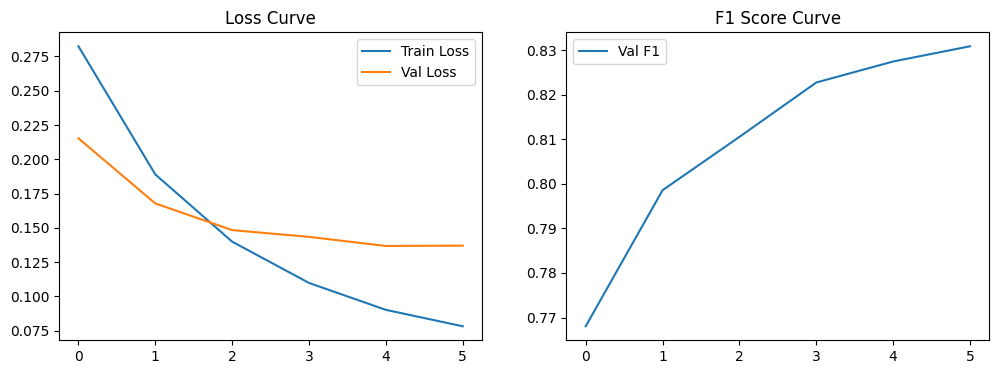

<All keys matched successfully>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_scheduler
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

MODEL_NAME = "DeepPavlov/rubert-base-cased"
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 6
LR = 2e-5
PATIENCE = 2
MODEL_PATH = "best_bert_model.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = list(X_train)
X_val = list(X_val)
y_train_np = y_train.values.astype(np.float32)
y_val_np = y_val.values.astype(np.float32)
NUM_CLASSES = y_train.shape[1]

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(
            texts,
            truncation=True,
            padding='max_length',
            max_length=MAX_LEN,
            return_tensors='pt'
        )
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

train_dataset = TextDataset(X_train, y_train_np)
val_dataset = TextDataset(X_val, y_val_np)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

class BERTClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        return self.classifier(x)

model = BERTClassifier(MODEL_NAME, NUM_CLASSES).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=EPOCHS * len(train_loader)
)

train_losses, val_losses, val_f1s = [], [], []
best_f1 = 0
epochs_no_improve = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            all_preds.append(torch.sigmoid(outputs).cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    preds = np.vstack(all_preds) > 0.5
    targets = np.vstack(all_labels)
    val_f1 = f1_score(targets, preds, average='macro')
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")

    if val_f1 > best_f1:
      best_f1 = val_f1
      torch.save(model.state_dict(), MODEL_PATH)
      drive_path = "/content/drive/MyDrive/best_bert_model.pt"
      torch.save(model.state_dict(), drive_path)
      print(f"✅ Best model saved to:\n - {MODEL_PATH}\n - {drive_path}")
      epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("🛑 Early stopping.")
            break

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(val_f1s, label="Val F1")
plt.legend()
plt.title("F1 Score Curve")
plt.show()

model.load_state_dict(torch.load(MODEL_PATH))

Я попробовала позапускать разные вариации этой модели, эта показала самые стабильные и высокие результаты, поэтому остановилась на ней. на кагле она показала результат 82%

In [ ]:
test_df = pd.read_csv("/content/data/test.csv")
submission_df = pd.read_csv("/content/data/sample_submission.csv")

test_df["id"] = test_df["id"].astype(int)
submission_df["id"] = submission_df["id"].astype(int)

model.eval()
test_texts = test_df["text"].tolist()

test_dataset = TextDataset(test_texts, np.zeros((len(test_texts), NUM_CLASSES)))  # пустые метки
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

all_preds = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > 0.4).astype(int)
        all_preds.extend(preds)

pred_labels = [" ".join(map(str, row)) for row in all_preds]

final_df = pd.DataFrame({
    "id": test_df["id"],
    "labels": pred_labels
})

submission = submission_df.drop(columns=["labels"]).merge(final_df, on="id", how="left")

submission.to_csv("submission.csv", index=False)
print("✅ submission.csv сохранён корректно и готов к отправке.")

Predicting: 100%|██████████| 462/462 [00:53<00:00,  8.62it/s]

✅ submission.csv сохранён корректно и готов к отправке.


Затем для этой модели я написала подбор трешхолдов, потому что это может улучшить результат

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Epoch 1: 100%|██████████| 1479/1479 [09:08<00:00,  2.70it/s]


Epoch 1 | Train Loss: 0.2780 | Val Loss: 0.2237 | Val F1: 0.7662
✅ Best model saved to:
 - best_bert_model_tr.pt
 - /content/drive/MyDrive/best_bert_model.pt


Epoch 2: 100%|██████████| 1479/1479 [09:09<00:00,  2.69it/s]


Epoch 2 | Train Loss: 0.1883 | Val Loss: 0.1709 | Val F1: 0.7955
✅ Best model saved to:
 - best_bert_model_tr.pt
 - /content/drive/MyDrive/best_bert_model.pt


Epoch 3: 100%|██████████| 1479/1479 [09:09<00:00,  2.69it/s]


Epoch 3 | Train Loss: 0.1385 | Val Loss: 0.1492 | Val F1: 0.8191
✅ Best model saved to:
 - best_bert_model_tr.pt
 - /content/drive/MyDrive/best_bert_model.pt


Epoch 4: 100%|██████████| 1479/1479 [09:09<00:00,  2.69it/s]


Epoch 4 | Train Loss: 0.1075 | Val Loss: 0.1395 | Val F1: 0.8341
✅ Best model saved to:
 - best_bert_model_tr.pt
 - /content/drive/MyDrive/best_bert_model.pt


Epoch 5: 100%|██████████| 1479/1479 [09:09<00:00,  2.69it/s]


Epoch 5 | Train Loss: 0.0859 | Val Loss: 0.1357 | Val F1: 0.8299
✅ Best model saved to:
 - best_bert_model_tr.pt
 - /content/drive/MyDrive/best_bert_model.pt


Epoch 6: 100%|██████████| 1479/1479 [09:09<00:00,  2.69it/s]


Epoch 6 | Train Loss: 0.0710 | Val Loss: 0.1362 | Val F1: 0.8352
✅ Best model saved to:
 - best_bert_model_tr.pt
 - /content/drive/MyDrive/best_bert_model.pt


Epoch 7: 100%|██████████| 1479/1479 [09:09<00:00,  2.69it/s]


Epoch 7 | Train Loss: 0.0618 | Val Loss: 0.1361 | Val F1: 0.8358


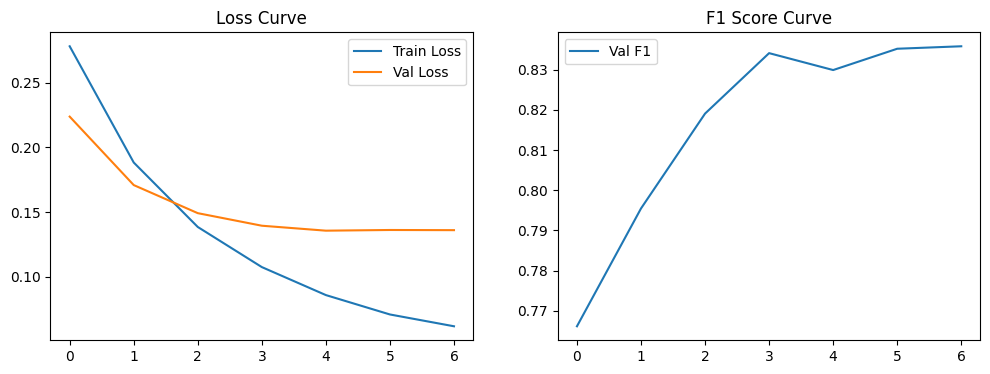

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([scalar])` or the `torch.serialization.safe_globals([scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_scheduler
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

MODEL_NAME = "DeepPavlov/rubert-base-cased"
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 7
LR = 2e-5
PATIENCE = 2
MODEL_PATH = "best_bert_model_tr.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = list(X_train)
X_val = list(X_val)
y_train_np = y_train.values.astype(np.float32)
y_val_np = y_val.values.astype(np.float32)
NUM_CLASSES = y_train.shape[1]

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(
            texts,
            truncation=True,
            padding='max_length',
            max_length=MAX_LEN,
            return_tensors='pt'
        )
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

train_dataset = TextDataset(X_train, y_train_np)
val_dataset = TextDataset(X_val, y_val_np)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

class BERTClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        return self.classifier(x)

model = BERTClassifier(MODEL_NAME, NUM_CLASSES).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=EPOCHS * len(train_loader)
)

train_losses, val_losses, val_f1s = [], [], []
best_f1 = 0
epochs_no_improve = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            all_preds.append(torch.sigmoid(outputs).cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    preds = np.vstack(all_preds) > 0.5
    targets = np.vstack(all_labels)
    val_f1 = f1_score(targets, preds, average='macro')
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")
    best_thresholds = []
    for class_idx in range(NUM_CLASSES):
        best_thresh = 0.5
        best_class_f1 = 0
        for t in np.linspace(0.1, 0.9, 17):
            pred_class = (np.vstack(all_preds)[:, class_idx] > t).astype(int)
            true_class = np.vstack(all_labels)[:, class_idx]
            score = f1_score(true_class, pred_class, zero_division=0)
            if score > best_class_f1:
                best_class_f1 = score
                best_thresh = t
        best_thresholds.append(best_thresh)

    adjusted_preds = (np.vstack(all_preds) > best_thresholds).astype(int)
    val_f1 = f1_score(np.vstack(all_labels), adjusted_preds, average='macro')
    if val_f1 > best_f1:
      best_f1 = val_f1
      torch.save({
        'model_state_dict': model.state_dict(),
        'best_thresholds': best_thresholds
      }, MODEL_PATH)
      drive_path = "/content/drive/MyDrive/best_bert_model_tr.pt"
      torch.save(model.state_dict(), drive_path)
      print(f"✅ Best model saved to:\n - {MODEL_PATH}\n - {drive_path}")
      epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("🛑 Early stopping.")
            break

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(val_f1s, label="Val F1")
plt.legend()
plt.title("F1 Score Curve")
plt.show()

model.load_state_dict(torch.load(MODEL_PATH))

In [ ]:
best_thresholds # посмотрим на реультаты

[np.float64(0.25),
 np.float64(0.45000000000000007),
 np.float64(0.30000000000000004),
 np.float64(0.30000000000000004),
 np.float64(0.4),
 np.float64(0.15000000000000002),
 np.float64(0.15000000000000002),
 np.float64(0.4),
 np.float64(0.35),
 np.float64(0.6),
 np.float64(0.5),
 np.float64(0.5),
 np.float64(0.5),
 np.float64(0.55),
 np.float64(0.5),
 np.float64(0.35),
 np.float64(0.4),
 np.float64(0.45000000000000007),
 np.float64(0.65),
 np.float64(0.5)]

In [ ]:
test_df = pd.read_csv("/content/data/test.csv")
submission_df = pd.read_csv("/content/data/sample_submission.csv")

test_df["id"] = test_df["id"].astype(int)
submission_df["id"] = submission_df["id"].astype(int)


model.eval()
test_texts = test_df["text"].tolist()

test_dataset = TextDataset(test_texts, np.zeros((len(test_texts), NUM_CLASSES)))  # пустые метки
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

all_preds = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy()

        preds = (probs > best_thresholds).astype(int)

        all_preds.extend(preds)

pred_labels = [" ".join(map(str, row)) for row in all_preds]

final_df = pd.DataFrame({
    "id": test_df["id"],
    "labels": pred_labels
})

submission = submission_df.drop(columns=["labels"]).merge(final_df, on="id", how="left")

submission.to_csv("submission.csv", index=False)
print("✅ submission.csv сохранён корректно и готов к отправке.")

Predicting: 100%|██████████| 462/462 [00:54<00:00,  8.48it/s]


✅ submission.csv сохранён корректно и готов к отправке.


# Блок 4. Генерация текстов

In [ ]:
import random
from collections import Counter

y_counts = y_train.astype(int).sum(axis=0).to_dict()
total = sum(y_counts.values())

label_distribution = {label: count / total for label, count in y_counts.items()}

def generate_label_mask(distribution, num_labels):
    mask = np.zeros(num_labels)
    for i in range(num_labels):
        if random.random() < distribution[y_train.columns[i]]:
            mask[i] = 1
    if not mask.any():
        mask[random.randint(0, num_labels - 1)] = 1
    return mask

In [ ]:
from transformers import pipeline

generator = pipeline("text-generation", model="sberbank-ai/rugpt3large_based_on_gpt2", device=0)

def generate_text(label_mask, max_length=128):
    active_labels = [name for i, name in enumerate(y_train.columns) if label_mask[i] == 1]
    prompt = f"Придумай короткий текст, который соответствует следующим темам: {', '.join(active_labels)}.\nТекст:"
    output = generator(prompt, max_new_tokens=max_length, do_sample=True, top_k=50, temperature=0.95)
    return output[0]["generated_text"].split("Текст:")[-1].strip()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/622 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.14G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
from transformers import pipeline

generator = pipeline("text-generation", model="sberbank-ai/rugpt3large_based_on_gpt2", device=0)

def generate_text(label_mask, max_length=128):
    active_labels = [name for i, name in enumerate(y_train.columns) if label_mask[i] == 1]
    if not active_labels:
        active_labels = ["общая тема"]
    prompt = f"Придумай короткий текст, который соответствует следующим темам: {', '.join(active_labels)}.\nТекст:"
    output = generator(prompt, max_new_tokens=max_length, do_sample=True, top_k=50, temperature=0.95)
    return output[0]["generated_text"].split("Текст:")[-1].strip()

Device set to use cuda:0


In [ ]:
import random
from tqdm import tqdm

label_masks = y_train.values
num_to_generate = 1000

generated_texts = []
generated_labels = []

for _ in tqdm(range(num_to_generate)):
    mask = random.choice(label_masks)
    text = generate_text(mask)
    generated_texts.append(text)
    generated_labels.append(mask)

generated_labels_np = np.array(generated_labels, dtype=np.float32)

  8%|▊         | 78/1000 [03:27<40:53,  2.66s/it]


KeyboardInterrupt: 

In [ ]:
import random
import numpy as np
from tqdm import tqdm
from transformers import pipeline

generator = pipeline("text-generation", model="sberbank-ai/rugpt3large_based_on_gpt2", device=0)

FEW_SHOT_EXAMPLES = 3
examples = list(zip(X_train, y_train.values))
num_to_generate = 1000
generated_texts = []
generated_labels = []

for _ in tqdm(range(num_to_generate)):
    shots = random.sample(examples, FEW_SHOT_EXAMPLES)

    prompt_parts = []
    for text, labels in shots:
        label_list = [f"label_{i}" for i, val in enumerate(labels) if val == 1]
        label_str = ", ".join(label_list)
        prompt_parts.append(f"Метки: {label_str}\nТекст: {text.strip()}")

    mask = random.choice(y_train.values)
    mask_label_list = [f"label_{i}" for i, val in enumerate(mask) if val == 1]
    target_label_str = ", ".join(mask_label_list)

    prompt = "\n\n".join(prompt_parts) + f"\n\nМетки: {target_label_str}\nТекст:"

    result = generator(prompt, max_new_tokens=100, do_sample=True, top_k=50, top_p=0.95)[0]["generated_text"]

    gen_text = result.split("Текст:")[-1].strip()

    if len(gen_text) > 20:
        generated_texts.append(gen_text)
        generated_labels.append(mask)

generated_labels_np = np.array(generated_labels, dtype=np.float32)

Device set to use cuda:0
100%|██████████| 1000/1000 [45:03<00:00,  2.70s/it]


In [ ]:
generated_texts[0]

'На Поклонной горе будут праздновать День народного единства.\nПодписание унии о передаче православных приходов и монастырей под контроль РПЦ.\nВ Кремле состоялось подписание унии, которая позволит РПЦ контролировать приходы и монастыри в других городах, передает «Интерфакс».\n☝\n👗\nА вот что пишет РБК:\n\n☝\n"Сейчас в России действуют только семь десятков религиозных объединений. Это значит, что с точки зрения государственного регулирования эта сфера должна быть либо'

при первых попытках у меня получались совсем неподходящие тексты, этот уже более менее нормальный, поэтому я оставила только этот блок с генерацией

In [ ]:
X_train_augmented = list(X_train) + generated_texts
y_train_augmented = np.vstack([y_train, generated_labels_np])
print(f"Новый размер трейна: {len(X_train_augmented)} текстов")

Новый размер трейна: 24604 текстов


посмотрим результаты на ранее выбранной лучшей модели (bert)

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Epoch 1: 100%|██████████| 1538/1538 [09:51<00:00,  2.60it/s]


Epoch 1 | Train Loss: 0.2992 | Val Loss: 0.2283 | Val F1: 0.7647
✅ Best model saved to best_bert_model_augmented.pt


Epoch 2: 100%|██████████| 1538/1538 [09:50<00:00,  2.61it/s]


Epoch 2 | Train Loss: 0.2128 | Val Loss: 0.1814 | Val F1: 0.7935
✅ Best model saved to best_bert_model_augmented.pt


Epoch 3: 100%|██████████| 1538/1538 [09:50<00:00,  2.60it/s]


Epoch 3 | Train Loss: 0.1647 | Val Loss: 0.1596 | Val F1: 0.8029
✅ Best model saved to best_bert_model_augmented.pt


Epoch 4: 100%|██████████| 1538/1538 [09:50<00:00,  2.60it/s]


Epoch 4 | Train Loss: 0.1345 | Val Loss: 0.1491 | Val F1: 0.8216
✅ Best model saved to best_bert_model_augmented.pt


Epoch 5: 100%|██████████| 1538/1538 [09:50<00:00,  2.60it/s]


Epoch 5 | Train Loss: 0.1168 | Val Loss: 0.1457 | Val F1: 0.8221
✅ Best model saved to best_bert_model_augmented.pt


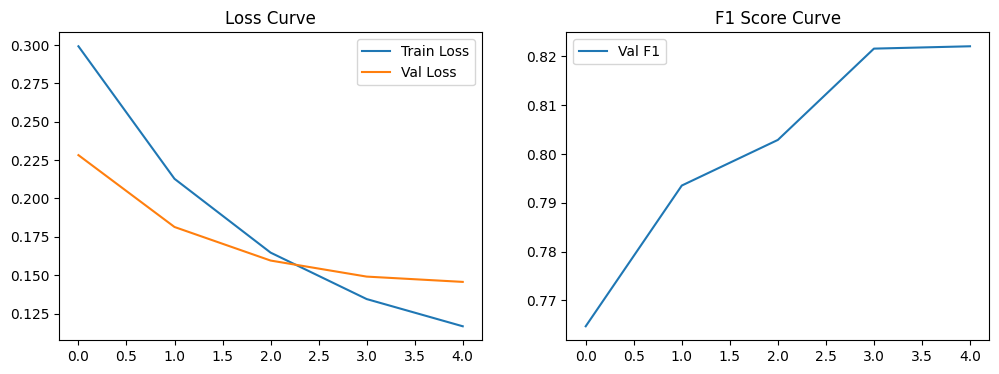

<All keys matched successfully>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_scheduler
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

MODEL_NAME = "DeepPavlov/rubert-base-cased"
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 5
LR = 2e-5
PATIENCE = 2
MODEL_PATH = "best_bert_model_augmented.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_augmented = list(X_train_augmented)
X_val = list(X_val)
y_train_augmented = y_train_augmented.astype(np.float32)
y_val_np = y_val.astype(np.float32).values
NUM_CLASSES = y_train_augmented.shape[1]

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(
            texts,
            truncation=True,
            padding='max_length',
            max_length=MAX_LEN,
            return_tensors='pt'
        )
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

train_dataset_aug = TextDataset(X_train_augmented, y_train_augmented)
val_dataset = TextDataset(X_val, y_val_np)

train_loader_aug = DataLoader(train_dataset_aug, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

class BERTClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        return self.classifier(x)

model = BERTClassifier(MODEL_NAME, NUM_CLASSES).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=EPOCHS * len(train_loader_aug)
)

train_losses, val_losses, val_f1s = [], [], []
best_f1 = 0
epochs_no_improve = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    for batch in tqdm(train_loader_aug, desc=f"Epoch {epoch + 1}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader_aug)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            all_preds.append(torch.sigmoid(outputs).cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    preds = np.vstack(all_preds) > 0.5
    targets = np.vstack(all_labels)
    val_f1 = f1_score(targets, preds, average='macro')
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"✅ Best model saved to {MODEL_PATH}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("🛑 Early stopping.")
            break

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(val_f1s, label="Val F1")
plt.legend()
plt.title("F1 Score Curve")
plt.show()

model.load_state_dict(torch.load(MODEL_PATH))

результаты с добавлением сгенерированных текстов стали чуть хуже (разница менее 1%). Это может быть связано с тем, что сгенерированные данные были менее разнообразны, чем реальные, и ухудшили обобщающую способность модели. Возможным объяснением также может быть изменение распределения признаков и меток, потому что изначально классы были сильно несбалансированными (очень мало представителей 5 и 6)

# Модель для загрузки на кагл

Лучше всего себя показала bert модель с подбором трешхолдов. Далее продублирован весь код, который нужен для обучения и загрузки результатов

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/dl-2025-study-competition-2.zip'
extract_path = '/content/data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.listdir(extract_path)

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import copy
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemme
import pandas as pd

df = pd.read_csv('/content/data/train.csv')
df['label_vector'] = df['labels'].apply(lambda x: list(map(int, x.strip().split())))
label_matrix = np.array(df['label_vector'].tolist())
class_counts = label_matrix.sum(axis=0)
text_column = 'text'
target_columns = [col for col in df.columns if col != text_column]


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_scheduler
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

MODEL_NAME = "DeepPavlov/rubert-base-cased"
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 7
LR = 2e-5
PATIENCE = 2
MODEL_PATH = "best_bert_model_tr.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = list(X_train)
X_val = list(X_val)
y_train_np = y_train.values.astype(np.float32)
y_val_np = y_val.values.astype(np.float32)
NUM_CLASSES = y_train.shape[1]

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(
            texts,
            truncation=True,
            padding='max_length',
            max_length=MAX_LEN,
            return_tensors='pt'
        )
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

train_dataset = TextDataset(X_train, y_train_np)
val_dataset = TextDataset(X_val, y_val_np)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

class BERTClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        return self.classifier(x)

model = BERTClassifier(MODEL_NAME, NUM_CLASSES).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=EPOCHS * len(train_loader)
)

train_losses, val_losses, val_f1s = [], [], []
best_f1 = 0
epochs_no_improve = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            all_preds.append(torch.sigmoid(outputs).cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    preds = np.vstack(all_preds) > 0.5
    targets = np.vstack(all_labels)
    val_f1 = f1_score(targets, preds, average='macro')
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")
    best_thresholds = []
    for class_idx in range(NUM_CLASSES):
        best_thresh = 0.5
        best_class_f1 = 0
        for t in np.linspace(0.1, 0.9, 17):
            pred_class = (np.vstack(all_preds)[:, class_idx] > t).astype(int)
            true_class = np.vstack(all_labels)[:, class_idx]
            score = f1_score(true_class, pred_class, zero_division=0)
            if score > best_class_f1:
                best_class_f1 = score
                best_thresh = t
        best_thresholds.append(best_thresh)

    adjusted_preds = (np.vstack(all_preds) > best_thresholds).astype(int)
    val_f1 = f1_score(np.vstack(all_labels), adjusted_preds, average='macro')
    if val_f1 > best_f1:
      best_f1 = val_f1
      torch.save({
        'model_state_dict': model.state_dict(),
        'best_thresholds': best_thresholds
      }, MODEL_PATH)
      drive_path = "/content/drive/MyDrive/best_bert_model_tr.pt"
      torch.save(model.state_dict(), drive_path)
      print(f"✅ Best model saved to:\n - {MODEL_PATH}\n - {drive_path}")
      epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("🛑 Early stopping.")
            break

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(val_f1s, label="Val F1")
plt.legend()
plt.title("F1 Score Curve")
plt.show()

model.load_state_dict(torch.load(MODEL_PATH))

In [ ]:
test_df = pd.read_csv("/content/data/test.csv")
submission_df = pd.read_csv("/content/data/sample_submission.csv")

test_df["id"] = test_df["id"].astype(int)
submission_df["id"] = submission_df["id"].astype(int)


model.eval()
test_texts = test_df["text"].tolist()

test_dataset = TextDataset(test_texts, np.zeros((len(test_texts), NUM_CLASSES)))  # пустые метки
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

all_preds = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy()

        preds = (probs > best_thresholds).astype(int)

        all_preds.extend(preds)

pred_labels = [" ".join(map(str, row)) for row in all_preds]

final_df = pd.DataFrame({
    "id": test_df["id"],
    "labels": pred_labels
})

submission = submission_df.drop(columns=["labels"]).merge(final_df, on="id", how="left")

submission.to_csv("submission.csv", index=False)
print("✅ submission.csv сохранён корректно и готов к отправке.")